/home/necphy/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_1707475/1922792067.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weig

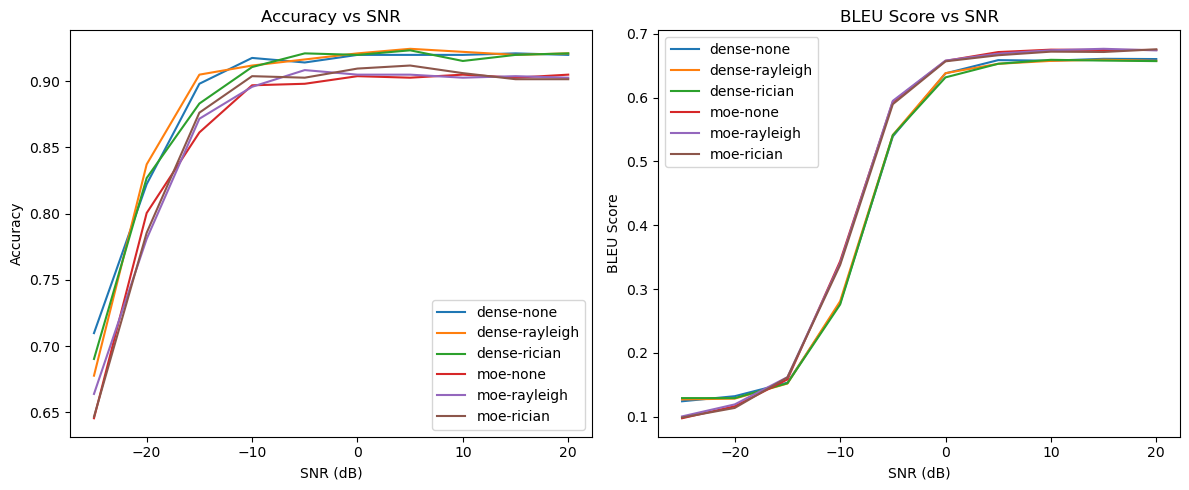

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom
from utils import collate_fn, SST2Dataset, fix_seed

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
fix_seed(2026)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_moe = MoE_SemCom(num_tasks=2, embed_dim=256, task_dim=16, num_experts=4).to(device)
model_dense = Transformer_SemCom(num_tasks=2, embed_dim=256, task_dim=16).to(device)
model_moe.load_state_dict(torch.load("checkpoints/model_MoE.pt"))
model_dense.load_state_dict(torch.load("checkpoints/model_dense.pt"))
model_moe.eval()
model_dense.eval()

# Load data
dataset = load_dataset("glue", "sst2", cache_dir='/home/necphy/.cache/huggingface/datasets')
test_dataset = SST2Dataset(dataset['validation'])
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

snr_range = np.arange(-25, 25, 5)
fading_range = ['none', 'rayleigh', 'rician']

# Results dicts
results = {
    'dense': {'accuracy': {'none': [], 'rayleigh': [], 'rician': []}, 'bleu': {'none': [], 'rayleigh': [], 'rician': []}},
    'moe': {'accuracy': {'none': [], 'rayleigh': [], 'rician': []}, 'bleu': {'none': [], 'rayleigh': [], 'rician': []}}
}

# Main loop
for snr in snr_range:
    for fading in fading_range:
        metrics = {'dense': {'correct': 0, 'total': 0, 'bleu_scores': []},
                   'moe': {'correct': 0, 'total': 0, 'bleu_scores': []}}

        for texts, labels in test_loader:
            # texts, labels = texts.to(device), labels.to(device)
            for arch_name, model in [('dense', model_dense), ('moe', model_moe)]:
                for task in [0, 1]:
                    with torch.no_grad():
                        outputs, input_ids, _, _, _ = model(texts, task, snr=float(snr), fading=fading)
                        
                        if task == 0:  # Classification
                            logits = outputs
                            preds = logits.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs
                            tgt_ids_batch = input_ids[:, 1:1 + pred_ids_batch.shape[1]]
                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=True)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=True)
                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)
        
        # Aggregate metrics
        for arch_name in ['dense', 'moe']:
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total']
            bleu = np.mean(metrics[arch_name]['bleu_scores'])
            results[arch_name]['accuracy'][fading].append(acc)
            results[arch_name]['bleu'][fading].append(bleu)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
for arch in ['dense', 'moe']:
    for fading in fading_range:
        axs[0].plot(snr_range, results[arch]['accuracy'][fading], label=f'{arch}-{fading}')
axs[0].set_title('Accuracy vs SNR')
axs[0].set_xlabel('SNR (dB)')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# BLEU plot
for arch in ['dense', 'moe']:
    for fading in fading_range:
        axs[1].plot(snr_range, results[arch]['bleu'][fading], label=f'{arch}-{fading}')
axs[1].set_title('BLEU Score vs SNR')
axs[1].set_xlabel('SNR (dB)')
axs[1].set_ylabel('BLEU Score')
axs[1].legend()

plt.tight_layout()
plt.show()


In [21]:
# def count_active_moe_params(model, k_active_experts):
#     total = 0
#     for name, param in model.named_parameters():
#         if 'experts' in name:  # assuming your experts layers are under 'experts'
#             total += param.numel() * (k_active_experts / 4)  # only k experts active
#         else:
#             total += param.numel()  # shared layers always active
#     return total

import re

def count_moe_params(model, k_active_experts):
    total_params = 0
    active_params = 0
    expert_group_params = {}

    for name, param in model.named_parameters():
        num_params = param.numel()
        total_params += num_params

        if 'experts' in name:
            # Use regex to extract group and expert index
            match = re.search(r'(.*experts)\.(\d+)\.', name)
            if match:
                group_name = match.group(1)
                expert_idx = int(match.group(2))
                expert_group_params.setdefault(group_name, {})
                expert_group_params[group_name].setdefault(expert_idx, 0)
                expert_group_params[group_name][expert_idx] += num_params
        else:
            active_params += num_params

    print("\nExpert Groups Debug Info:")
    for group, experts in expert_group_params.items():
        print(f"Group: {group}, Experts: {len(experts)}, Total Expert Params: {sum(experts.values())}")

    # Scale active params
    for group, experts in expert_group_params.items():
        group_total = sum(experts.values())
        num_experts = len(experts)
        active_params += group_total * (k_active_experts / num_experts)

    return total_params, int(active_params)

def params_per_expert(params_list):
    # Assuming experts have equal parameter sizes
    # Divide total params by number of experts
    return len(params_list)

def count_total_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

dense_total_params = count_total_params(model_dense)
moe_total, moe_active = count_moe_params(model_moe, k_active_experts=2)

print(f"Dense model total params: {dense_total_params}")
print(f"MoE model total params: {moe_total}")
print(f"MoE model active params (with 2 active experts): {moe_active}")


Expert Groups Debug Info:
Group: encoder_transformer.layers.0.moe_ffn.experts, Experts: 4, Total Expert Params: 1117248
Group: encoder_transformer.layers.1.moe_ffn.experts, Experts: 4, Total Expert Params: 1117248
Group: decoder_transformer.layers.0.moe_ffn.experts, Experts: 4, Total Expert Params: 1117248
Group: decoder_transformer.layers.1.moe_ffn.experts, Experts: 4, Total Expert Params: 1117248
Dense model total params: 135450836
MoE model total params: 135756580
MoE model active params (with 2 active experts): 133522084


In [23]:
import re

def count_total_params_exclude(model):
    """Total parameters excluding text_encoder and output_head."""
    total_params = 0
    for name, param in model.named_parameters():
        if ('text_encoder' in name) or ('output_head' in name):
            continue  # Skip frozen/pretrained parts
        total_params += param.numel()
    return total_params

def count_moe_params_exclude(model, k_active_experts):
    total_params = 0
    active_params = 0
    expert_group_params = {}  # {group_name: {expert_idx: param_count}}

    for name, param in model.named_parameters():
        if ('text_encoder' in name) or ('output_head' in name):
            continue  # Skip frozen/pretrained parts

        num_params = param.numel()
        total_params += num_params

        if 'experts' in name:
            # Extract expert group and expert index
            match = re.search(r'(.*experts)\.(\d+)\.', name)
            if match:
                group_name = match.group(1)  # Group without expert index
                expert_idx = int(match.group(2))
                expert_group_params.setdefault(group_name, {})
                expert_group_params[group_name].setdefault(expert_idx, 0)
                expert_group_params[group_name][expert_idx] += num_params
        else:
            active_params += num_params  # Shared layers always active

    print("\nExpert Groups Debug Info (excluding text_encoder/output_head):")
    for group, experts in expert_group_params.items():
        group_total = sum(experts.values())
        num_experts = len(experts)
        print(f"{group} - Total Expert Params: {group_total}, Experts: {num_experts}")

    # Scale expert params for active experts
    print("\nLayer-wise active parameter savings:")
    for group, experts in expert_group_params.items():
        group_total = sum(experts.values())
        num_experts = len(experts)
        group_active = group_total * (k_active_experts / num_experts)
        active_params += group_active
        print(f"{group} - Total: {group_total}, Active: {int(group_active)} ({k_active_experts}/{num_experts} experts active)")

    return total_params, int(active_params)

# === Example usage ===

dense_total_params = count_total_params_exclude(model_dense)
moe_total_params, moe_active_params = count_moe_params_exclude(model_moe, k_active_experts=2)

print("\nFinal Results:")
print(f"Dense model total params (excluding frozen parts): {dense_total_params}")
print(f"MoE model total params (excluding frozen parts): {moe_total_params}")
print(f"MoE model active params (with {2} active experts): {moe_active_params}")
print(f"Active params reduction: {1 - (moe_active_params / moe_total_params):.4f}")



Expert Groups Debug Info (excluding text_encoder/output_head):
encoder_transformer.layers.0.moe_ffn.experts - Total Expert Params: 1117248, Experts: 4
encoder_transformer.layers.1.moe_ffn.experts - Total Expert Params: 1117248, Experts: 4
decoder_transformer.layers.0.moe_ffn.experts - Total Expert Params: 1117248, Experts: 4
decoder_transformer.layers.1.moe_ffn.experts - Total Expert Params: 1117248, Experts: 4

Layer-wise active parameter savings:
encoder_transformer.layers.0.moe_ffn.experts - Total: 1117248, Active: 558624 (2/4 experts active)
encoder_transformer.layers.1.moe_ffn.experts - Total: 1117248, Active: 558624 (2/4 experts active)
decoder_transformer.layers.0.moe_ffn.experts - Total: 1117248, Active: 558624 (2/4 experts active)
decoder_transformer.layers.1.moe_ffn.experts - Total: 1117248, Active: 558624 (2/4 experts active)

Final Results:
Dense model total params (excluding frozen parts): 5658208
MoE model total params (excluding frozen parts): 5963952
MoE model active p

/home/necphy/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_462930/1864589123.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weigh

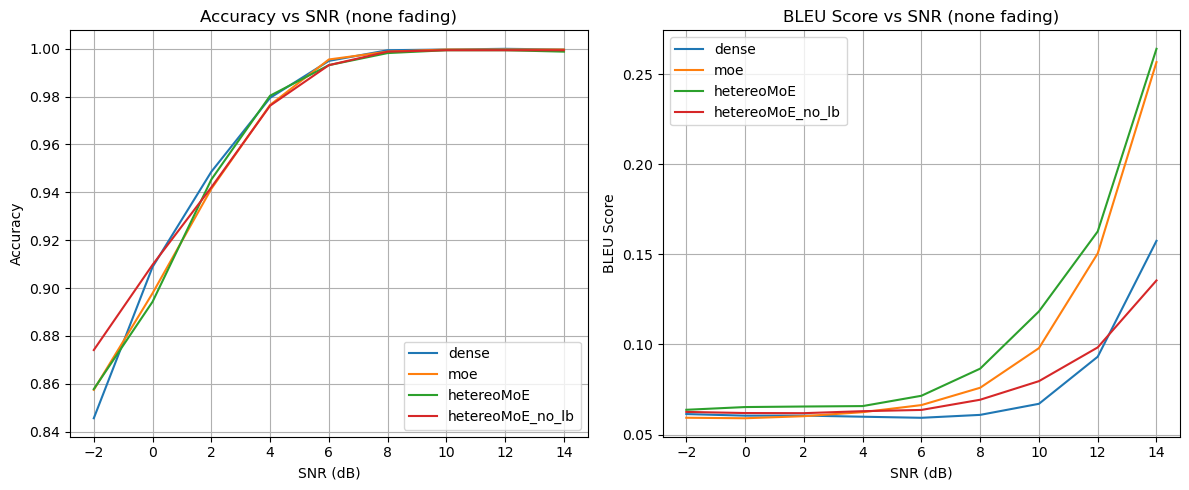

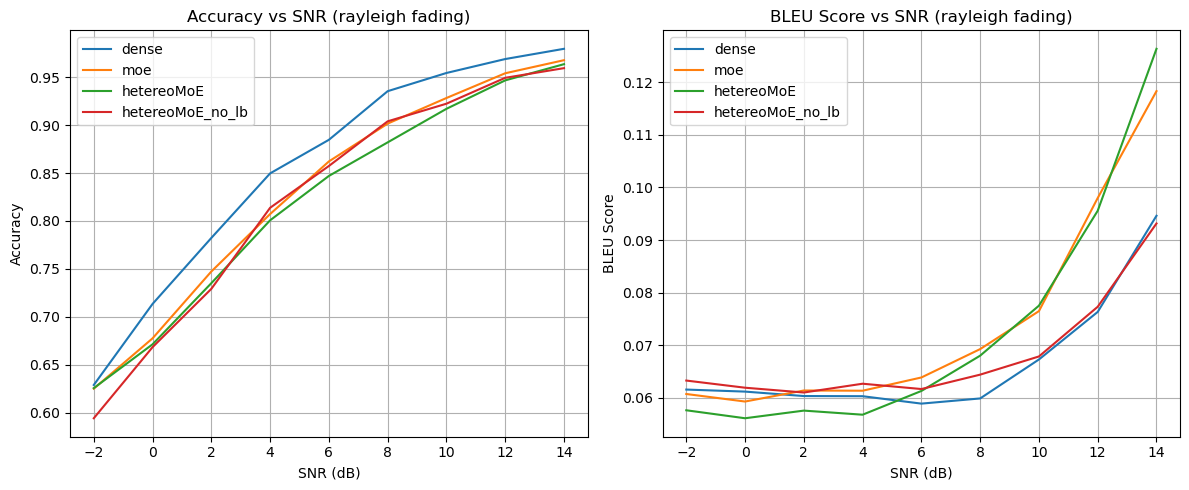

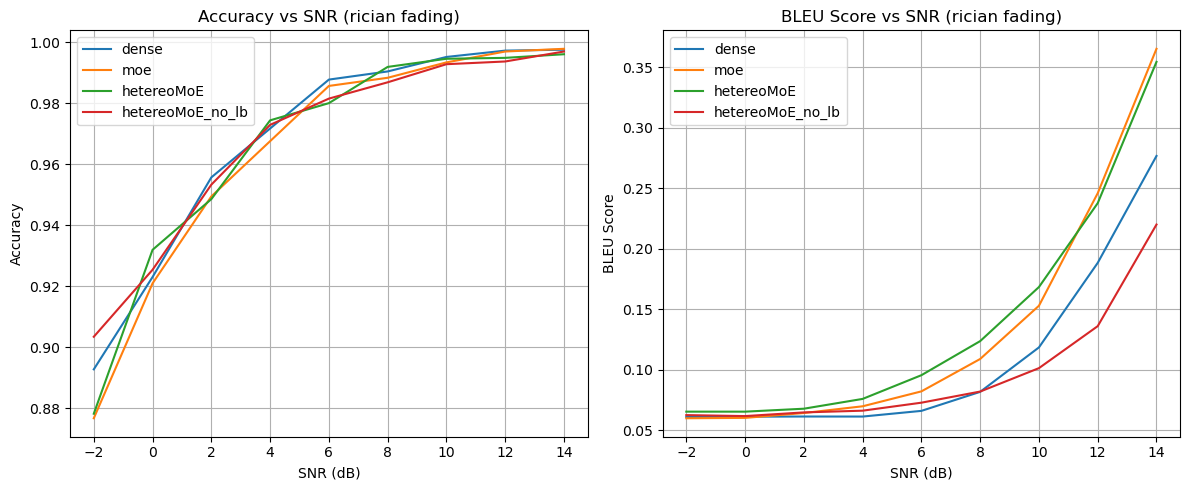

: 

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ['HF_DATASETS_OFFLINE'] = '1'

import torch, random
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom  # assuming this class exists
from utils import collate_fn, SST2Dataset, fix_seed

# Setup
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
fix_seed(2006) # 2036
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
model_moe = MoE_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_experts=8, transmit_dim=128, num_encd_layer=4).to(device)
model_dense = Transformer_SemCom(num_tasks=2, embed_dim=256, task_dim=8, transmit_dim=128, num_encd_layer=4).to(device)
model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4).to(device)  # NEW
model_hetereo_no_lb = HetereoMoE_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4).to(device)  # NEW

model_moe.load_state_dict(torch.load("checkpoints/MoE_encdlayer_20250524_044548.pt"))
model_dense.load_state_dict(torch.load("checkpoints/Dense_encdlayer_20250523_154825.pt"))
model_hetereo.load_state_dict(torch.load("checkpoints/HetereoMoE_encdlayer_20250524_110806.pt"))  # NEW
model_hetereo_no_lb.load_state_dict(torch.load("checkpoints/HetereoMoE_encdlayer_20250529_100757.pt"))  # NEW

#HetereoMoE_encdlayer_20250529_100757

model_moe.eval()
model_dense.eval()
model_hetereo.eval()
model_hetereo_no_lb.eval()  # NEW

# Load data
dataset = load_dataset("glue", "sst2", cache_dir='/home/necphy/.cache/huggingface/datasets')
# test_dataset = SST2Dataset(dataset['validation'])
# test_dataset = SST2Dataset(dataset['train'])
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

full_train_dataset = dataset['train']
subset_indices = random.sample(range(len(full_train_dataset)), len(full_train_dataset) // 20)
small_train_dataset = full_train_dataset.select(subset_indices)
test_dataset = SST2Dataset(small_train_dataset)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)


snr_range = np.arange(-2, 16, 2)
fading_range = ['none', 'rayleigh', 'rician']

# Results dicts
results = {
    'dense': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'moe': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},
    'hetereoMoE': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},  #
    'hetereoMoE_no_lb': {'accuracy': {f: [] for f in fading_range}, 'bleu': {f: [] for f in fading_range}},  # NEW
}

# Main evaluation loop
for snr in snr_range:
    for fading in fading_range:
        metrics = {arch: {'correct': 0, 'total': 0, 'bleu_scores': []} for arch in results.keys()}

        for texts, labels in test_loader:
            for arch_name, model in [('dense', model_dense), ('moe', model_moe), ('hetereoMoE', model_hetereo), ('hetereoMoE_no_lb', model_hetereo_no_lb)]:  # NEW
                for task in [0, 1]:
                    with torch.no_grad():
                        if arch_name == 'dense':
                            outputs, input_ids, _, _, _ = model(texts, task, snr=float(snr), fading=fading)
                        else:
                            outputs, input_ids, input_lengths, semantic_encoded, semantic_decoded, gate_scores, expert_masks = model(texts, task, float(snr), fading) 

                        if task == 0:  # Classification
                            logits = outputs
                            preds = logits.argmax(dim=-1)
                            metrics[arch_name]['correct'] += (preds == labels.to(device)).sum().item()
                            metrics[arch_name]['total'] += labels.size(0)

                        elif task == 1:  # Reconstruction
                            pred_ids_batch = outputs
                            tgt_ids_batch = input_ids[:, 1:1 + pred_ids_batch.shape[1]]
                            pred_texts = tokenizer.batch_decode(pred_ids_batch, skip_special_tokens=True)
                            target_texts = tokenizer.batch_decode(tgt_ids_batch, skip_special_tokens=True)
                            for pred_text, target_text in zip(pred_texts, target_texts):
                                bleu = sentence_bleu(
                                    [word_tokenize(target_text)],
                                    word_tokenize(pred_text),
                                    weights=(1, 0, 0, 0),
                                    smoothing_function=SmoothingFunction().method4
                                )
                                metrics[arch_name]['bleu_scores'].append(bleu)

        # Aggregate
        for arch_name in results.keys():
            acc = metrics[arch_name]['correct'] / metrics[arch_name]['total']
            bleu = np.mean(metrics[arch_name]['bleu_scores'])
            results[arch_name]['accuracy'][fading].append(acc)
            results[arch_name]['bleu'][fading].append(bleu)

# Plotting: 3 figures, one per fading
model_types = ['dense', 'moe', 'hetereoMoE', 'hetereoMoE_no_lb']  # NEW

for fading in fading_range:
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    for model in model_types:
        axs[0].plot(snr_range, results[model]['accuracy'][fading], label=model)
    axs[0].set_title(f'Accuracy vs SNR ({fading} fading)')
    axs[0].set_xlabel('SNR (dB)')
    axs[0].set_ylabel('Accuracy')
    axs[0].legend()
    axs[0].grid(True)

    # BLEU plot
    for model in model_types:
        axs[1].plot(snr_range, results[model]['bleu'][fading], label=model)
    axs[1].set_title(f'BLEU Score vs SNR ({fading} fading)')
    axs[1].set_xlabel('SNR (dB)')
    axs[1].set_ylabel('BLEU Score')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


Using the latest cached version of the dataset since glue couldn't be found on the Hugging Face Hub (offline mode is enabled).
Found the latest cached dataset configuration 'sst2' at /home/necphy/.cache/huggingface/datasets/glue/sst2/0.0.0/bcdcba79d07bc864c1c254ccfcedcce55bcc9a8c (last modified on Thu Jun 19 18:41:12 2025).


Processing SNR=12.0, Fading=rician, Task=0


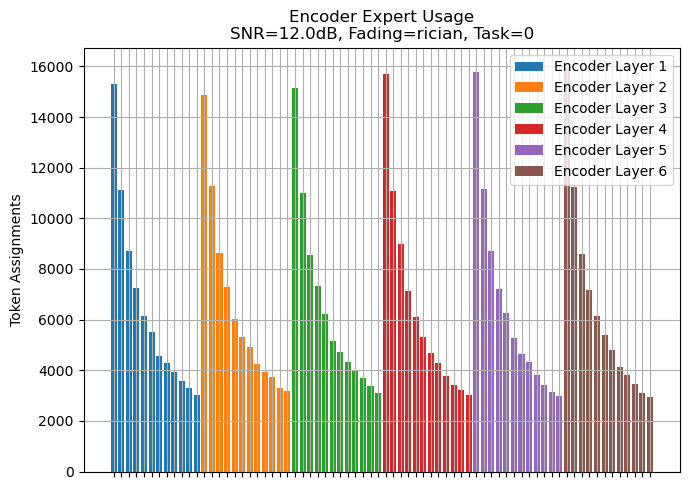

In [ ]:
import os, random
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import torch
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from torch.utils.data import DataLoader
from transformers import BertTokenizer
from collections import defaultdict

from semcom_model import MoE_SemCom, Transformer_SemCom, HetereoMoE_SemCom
from utils import collate_fn, SST2Dataset, fix_seed


tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# fix_seed(2006)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load models
# model_moe = MoE_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_experts=8, transmit_dim=128, num_encd_layer=4).to(device)
# model_dense = Transformer_SemCom(num_tasks=2, embed_dim=256, task_dim=8, transmit_dim=128, num_encd_layer=4).to(device)

model_hetereo = HetereoMoE_SemCom(num_tasks=2, embed_dim=632, task_dim=8, num_experts=12, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=6, num_heads=8).to(device) 

# model_moe.load_state_dict(torch.load("checkpoints/MoE_encdlayer_20250524_044548.pt"))
# model_dense.load_state_dict(torch.load("checkpoints/Dense_encdlayer_20250523_154825.pt"))
model_hetereo.load_state_dict(torch.load("checkpoints/HMoE_sizeL_6_12_8_632_20250622_101333.pt", weights_only=True)) 

# model_moe.eval()
# model_dense.eval()
model_hetereo.eval()

# Load data
dataset = load_dataset("glue", "sst2", cache_dir='/home/necphy/.cache/huggingface/datasets')
# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

full_train_dataset = dataset['train']
subset_indices = random.sample(range(len(full_train_dataset)), len(full_train_dataset) // 80)
small_train_dataset = full_train_dataset.select(subset_indices)
test_dataset = SST2Dataset(small_train_dataset)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

# Parameters
# snr_range = np.arange(-10, 20, 5)
snr_range = np.array([12.0])  
fading_range = ['rician']
task_ids = [0]  

# Run for each SNR and fading
for snr in snr_range:
    for fading in fading_range:
        for task in task_ids:
            print(f"Processing SNR={snr}, Fading={fading}, Task={task}")

            # Use a dummy batch to determine encoder/decoder MoE split
            for texts, labels in test_loader:
                with torch.no_grad():
                    _, _, _, _, _, _, expert_masks = model_hetereo(texts, task, snr=float(snr), fading=fading) # (num_layers, num_tokens, num_experts)

                    # print(sum(expert_masks[0][:, -1]))
                break

            num_layers_total = len(expert_masks)
            # print(len(expert_masks), expert_masks[0].shape)

            num_layers_each = num_layers_total # number of layers in each transformer-based semantic encoder/decoder
            expert_usage_encoder = [defaultdict(int) for _ in range(num_layers_each)]
            # expert_usage_decoder = [defaultdict(int) for _ in range(num_layers_each)]

            # Accumulate expert usage
            for texts, labels in test_loader:
                with torch.no_grad():
                    _, _, _, _, _, _, expert_masks = model_hetereo(texts, task, snr=float(snr), fading=fading)


                for i, mask in enumerate(expert_masks): # mask shape: (num_tokens, num_experts)
                    topk_experts = torch.topk(mask, k=2, dim=-1).indices.cpu().numpy()

                    usage_dict = expert_usage_encoder[i]
                    # else:
                    #     usage_dict = expert_usage_decoder[i - num_layers_each]

                    for expert_ids in topk_experts:
                        for expert_id in expert_ids:
                            usage_dict[int(expert_id)] += 1

            # Plotting
            # fig, axs = plt.subplots(1, 2, figsize=(14, 5))
            fig, axs = plt.subplots(figsize=(7, 5))

            # Encoder Plot
            for i, usage_dict in enumerate(expert_usage_encoder):
                experts = sorted(usage_dict.keys())
                # experts = list(range(16))  # fixed list

                counts = [usage_dict[e] for e in experts]
                axs.bar([f'EncL{i+1}_E{e}' for e in experts], counts, label=f'Encoder Layer {i+1}')
                # axs[0].bar(range(len(experts)), counts, label=f'Encoder Layer {i+1}')


            axs.set_title(f'Encoder Expert Usage\nSNR={snr}dB, Fading={fading}, Task={task}')
            axs.set_ylabel('Token Assignments')
            axs.set_xticklabels([])
            # axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
            axs.legend(loc='upper right')
            axs.grid(True)

            # Decoder Plot
            # for i, usage_dict in enumerate(expert_usage_decoder):
            #     experts = sorted(usage_dict.keys())
            #     # experts = list(range(16))  # fixed list

            #     counts = [usage_dict[e] for e in experts]
            #     axs[1].bar([f'DecL{i+1}_E{e}' for e in experts], counts, label=f'Decoder Layer {i+1}')
            #     # axs[1].bar(range(len(experts)), counts, label=f'Decoder Layer {i+1}')

            # axs[1].set_title(f'Decoder Expert Usage\nSNR={snr}dB, Fading={fading}, Task={task}')
            # axs[1].set_ylabel('Token Assignments')
            # # axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
            # axs[1].set_xticklabels([])

            # axs[1].legend()
            # axs[1].grid(True)

            # axs[1].axis('off')
            plt.tight_layout()
            plt.show()


/tmp/ipykernel_3385446/2930555820.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_moe.load_state_dict(torch.load("checkpoints/HetereoMoE_encdlayer_20250524_110806.

Processing SNR=-2, Fading=none, Task=0


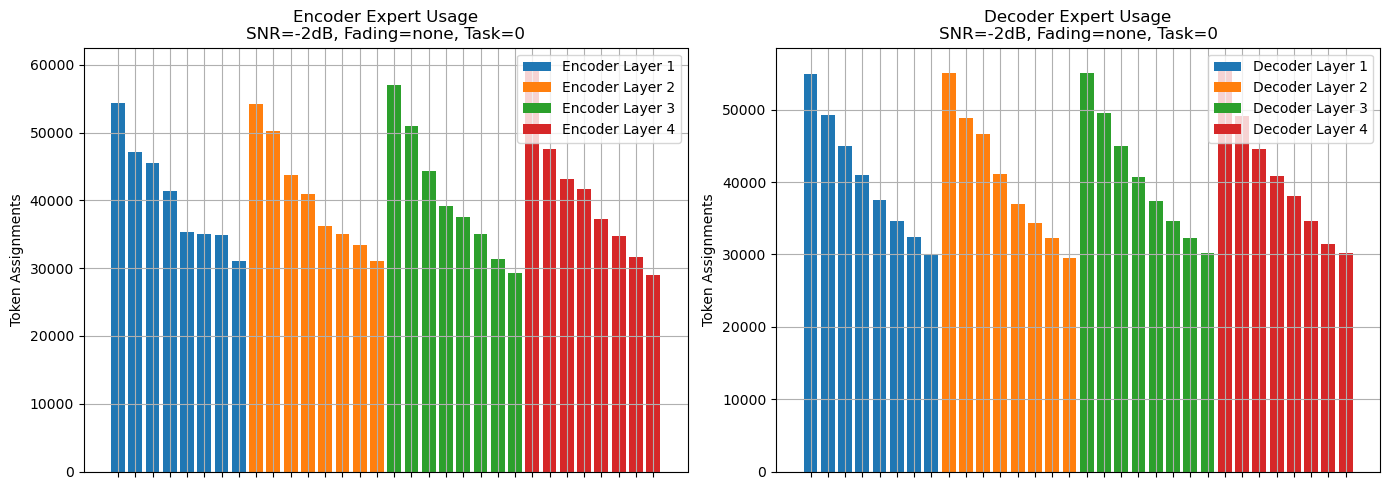

Processing SNR=-2, Fading=none, Task=1


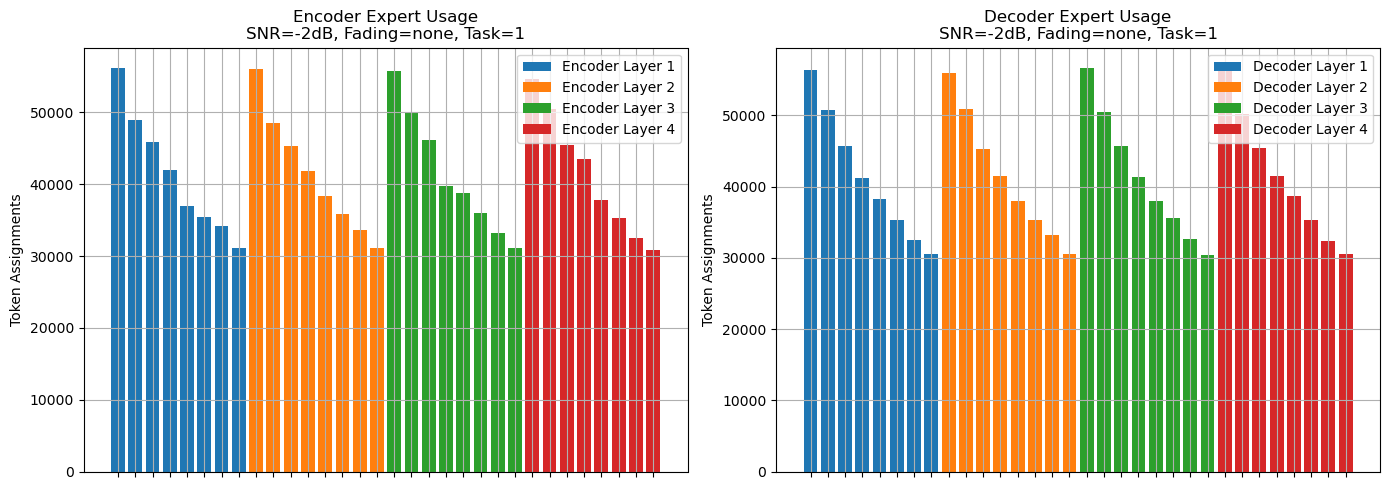

Processing SNR=-2, Fading=rician, Task=0


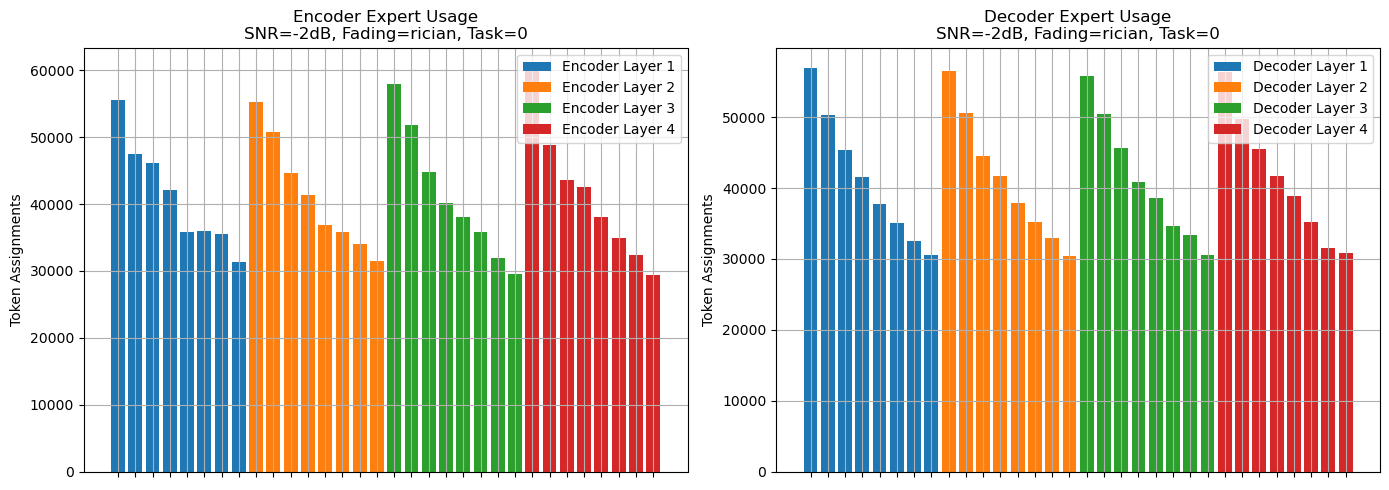

Processing SNR=-2, Fading=rician, Task=1


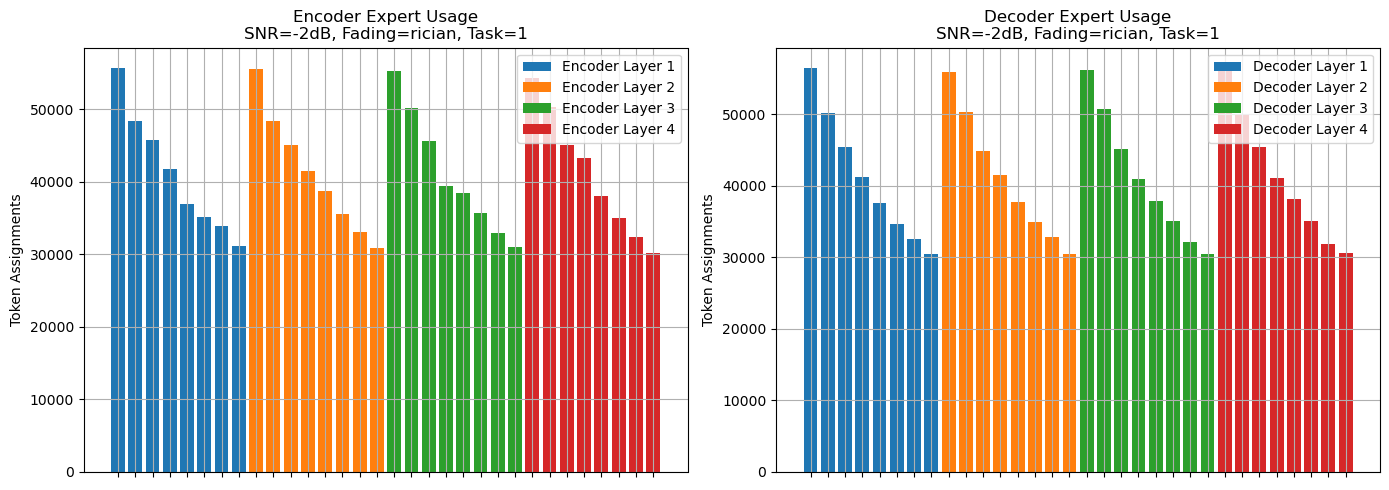

Processing SNR=10, Fading=none, Task=0


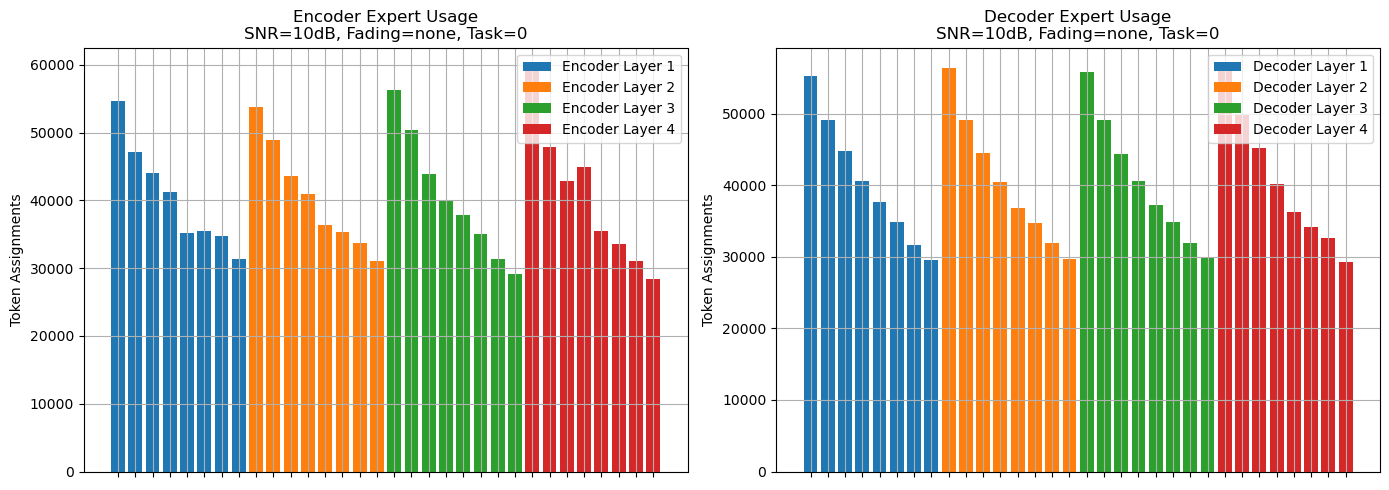

Processing SNR=10, Fading=none, Task=1


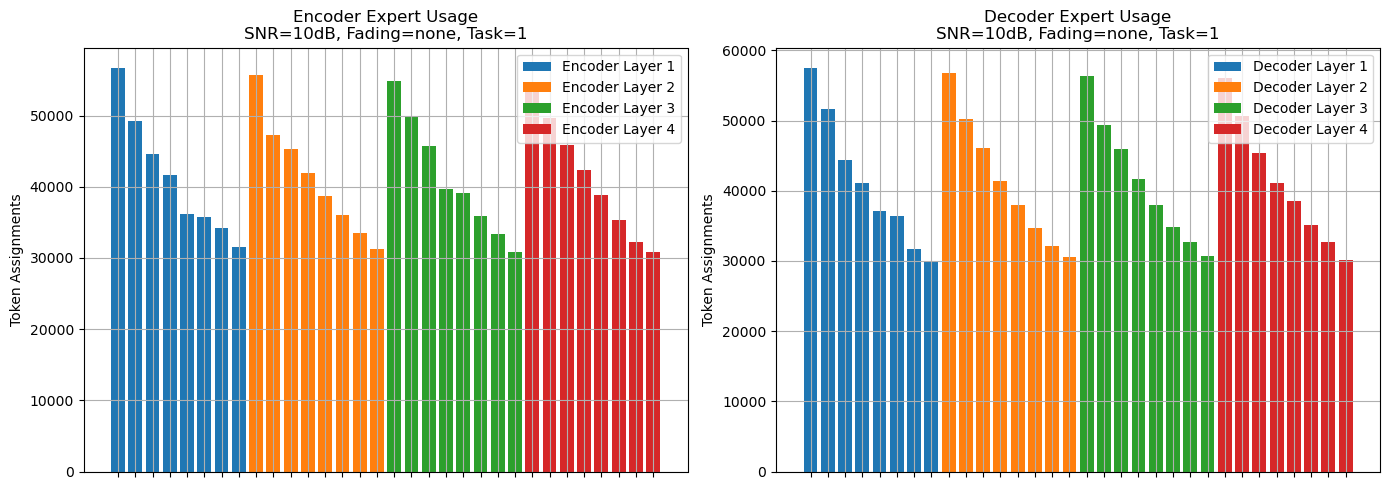

Processing SNR=10, Fading=rician, Task=0


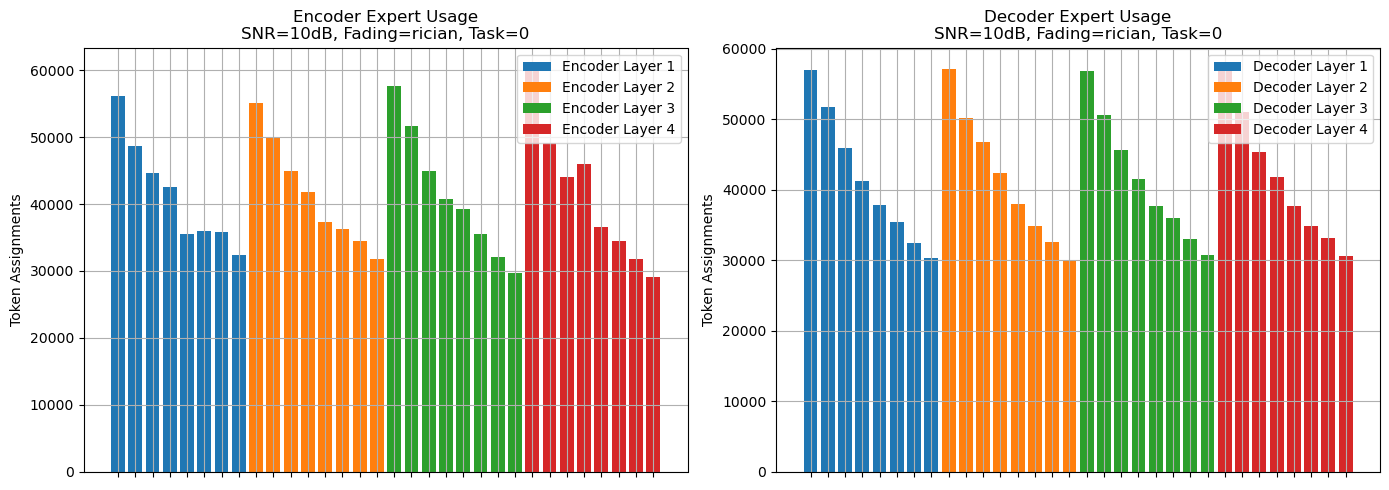

Processing SNR=10, Fading=rician, Task=1


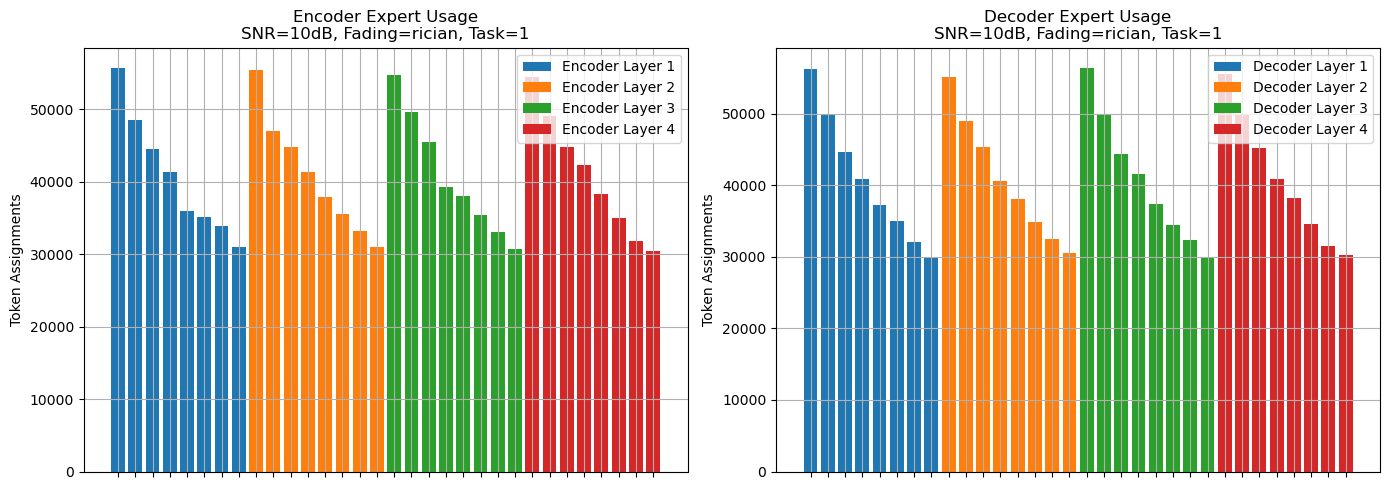

In [2]:
# Load models
# model_moe = MoE_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_experts=8, transmit_dim=128, num_encd_layer=4).to(device)
# model_dense = Transformer_SemCom(num_tasks=2, embed_dim=256, task_dim=8, transmit_dim=128, num_encd_layer=4).to(device)
model_moe = HetereoMoE_SemCom(num_tasks=2, embed_dim=256, task_dim=8, num_experts=8, size_distribution='arithmetic', transmit_dim=128, num_encd_layer=4).to(device)  # NEW

# model_moe.load_state_dict(torch.load("checkpoints/MoE_encdlayer_20250524_044548.pt"))
# model_dense.load_state_dict(torch.load("checkpoints/Dense_encdlayer_20250523_154825.pt"))
model_moe.load_state_dict(torch.load("checkpoints/HetereoMoE_encdlayer_20250524_110806.pt"))  # NEW

model_moe.eval()
# model_dense.eval()
# model_hetereo.eval()

# Load data
dataset = load_dataset("glue", "sst2", cache_dir='/home/necphy/.cache/huggingface/datasets')
# test_dataset = SST2Dataset(dataset['validation'])
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

full_train_dataset = dataset['train']
subset_indices = random.sample(range(len(full_train_dataset)), len(full_train_dataset) // 20)
small_train_dataset = full_train_dataset.select(subset_indices)
test_dataset = SST2Dataset(small_train_dataset)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)

# Parameters
# snr_range = np.arange(-10, 20, 5)
snr_range = np.array([-2, 10])  # Extended range for more granularity
fading_range = ['none', 'rician']
task_ids = [0, 1]  # Only reconstruction

# Run for each SNR and fading
for snr in snr_range:
    for fading in fading_range:
        for task in task_ids:
            print(f"Processing SNR={snr}, Fading={fading}, Task={task}")

            # Use a dummy batch to determine encoder/decoder MoE split
            for texts, labels in test_loader:
                with torch.no_grad():
                    _, _, _, _, _, _, expert_masks = model_moe(texts, task, snr=float(snr), fading=fading) # (num_layers, num_tokens, num_experts)

                    # print(sum(expert_masks[0][:, -1]))
                break

            num_layers_total = len(expert_masks)
            # print(len(expert_masks), expert_masks[0].shape)

            num_layers_each = num_layers_total // 2 # number of layers in each transformer-based semantic encoder/decoder
            expert_usage_encoder = [defaultdict(int) for _ in range(num_layers_each)]
            expert_usage_decoder = [defaultdict(int) for _ in range(num_layers_each)]

            # Accumulate expert usage
            for texts, labels in test_loader:
                with torch.no_grad():
                    _, _, _, _, _, _, expert_masks = model_moe(texts, task, snr=float(snr), fading=fading)


                for i, mask in enumerate(expert_masks): # mask shape: (num_tokens, num_experts)
                    topk_experts = torch.topk(mask, k=2, dim=-1).indices.cpu().numpy()


                    if i < num_layers_each:
                        usage_dict = expert_usage_encoder[i]
                    else:
                        usage_dict = expert_usage_decoder[i - num_layers_each]

                    for expert_ids in topk_experts:
                        for expert_id in expert_ids:
                            usage_dict[int(expert_id)] += 1

            # Plotting
            fig, axs = plt.subplots(1, 2, figsize=(14, 5))

            # Encoder Plot
            for i, usage_dict in enumerate(expert_usage_encoder):
                experts = sorted(usage_dict.keys())
                # experts = list(range(16))  # fixed list

                counts = [usage_dict[e] for e in experts]
                axs[0].bar([f'EncL{i+1}_E{e}' for e in experts], counts, label=f'Encoder Layer {i+1}')
                # axs[0].bar(range(len(experts)), counts, label=f'Encoder Layer {i+1}')


            axs[0].set_title(f'Encoder Expert Usage\nSNR={snr}dB, Fading={fading}, Task={task}')
            axs[0].set_ylabel('Token Assignments')
            axs[0].set_xticklabels([])
            # axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45, ha='right')
            axs[0].legend()
            axs[0].grid(True)

            # Decoder Plot
            for i, usage_dict in enumerate(expert_usage_decoder):
                experts = sorted(usage_dict.keys())
                # experts = list(range(16))  # fixed list

                counts = [usage_dict[e] for e in experts]
                axs[1].bar([f'DecL{i+1}_E{e}' for e in experts], counts, label=f'Decoder Layer {i+1}')
                # axs[1].bar(range(len(experts)), counts, label=f'Decoder Layer {i+1}')

            axs[1].set_title(f'Decoder Expert Usage\nSNR={snr}dB, Fading={fading}, Task={task}')
            axs[1].set_ylabel('Token Assignments')
            # axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45, ha='right')
            axs[1].set_xticklabels([])

            axs[1].legend()
            axs[1].grid(True)

            plt.tight_layout()
            plt.show()


In [5]:
import numpy as np 

hidden_dim = 512
num_experts = 12

gap = int(hidden_dim * 0.125)
a = hidden_dim - ((num_experts - 1) * gap) // 2

# Ensure all expert sizes are >= 1
expert_sizes = [max(1, a + i * gap) for i in range(num_experts)]

print(np.mean(expert_sizes))

512.0
